<a href="https://colab.research.google.com/github/HarinduR/FeatherFind/blob/Keyword-Bird-Finder/DSGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
# ----------------------
# Step 1: Load and Clean Data
# ----------------------
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("/content/bird_features_full_dataset.csv")

# Handle missing values
label_columns = ["Size", "Primary Color", "Secondary Color", "Habitat",
                 "Region", "Diet", "Beak Size", "Beak Color", "Legs Size",
                 "Legs Color", "Eyes Size", "Eyes Color"]

# Fill missing descriptions and labels
df["Description"] = df["Description"].fillna("none")
df[label_columns] = df[label_columns].fillna("none")

In [77]:
# ----------------------
# Step 2: Spit and prepare text lables
# ----------------------

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_text = train_df["Description"]
test_text = test_df["Description"]

def get_labels(row):
    return [f"{col}={val}" for col in label_columns
            if (val := row[col]) != "none"]

train_labels = train_df.apply(get_labels, axis=1)
test_labels = test_df.apply(get_labels, axis=1)

print(train_labels.count)

<bound method Series.count of 554     [Size=large, Primary Color=green, Secondary Co...
1012    [Size=small, Habitat=mountainous, Region=Europ...
481     [Size=large, Primary Color=black, Secondary Co...
432     [Size=small, Primary Color=yellow, Region=Afri...
626     [Size=medium, Primary Color=black, Habitat=wet...
                              ...                        
330     [Size=medium, Primary Color=brown, Habitat=des...
466     [Size=tiny, Primary Color=black, Diet=omnivoro...
121     [Size=small, Primary Color=blue, Region=Africa...
1044    [Size=giant, Primary Color=blue, Secondary Col...
860     [Size=medium, Primary Color=yellow, Habitat=de...
Length: 840, dtype: object>


In [78]:
# ----------------------
# Step 3: Vectorize Text
# ----------------------
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF features with enhanced settings
vectorizer = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 3),  # Include bigrams and trigrams
    stop_words='english'
)

X_train_org = vectorizer.fit_transform(train_text)
X_test_org = vectorizer.transform(test_text)

In [79]:

# ----------------------
# Step 4: Encode Labels
# ----------------------
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_train_org = mlb.fit_transform(train_labels)
y_test_org = mlb.transform(test_labels)


In [80]:
# ----------------------
# Step 5: Build Logistic Regression Model
# ----------------------
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

# Create classifier with balanced class weights
clf = MultiOutputClassifier(
    LogisticRegression(
        class_weight={0: 1, 1: 5},
        max_iter=1000,
        random_state=42
    )
)

# Train
clf.fit(X_train_org, y_train_org)


MultiOutputClassifier(estimator=LogisticRegression(class_weight={0: 1, 1: 5},
                                                   max_iter=1000,
                                                   random_state=42))

In [81]:
# ----------------------
# Step 6: Evaluate with Threshold Tuning
# ----------------------
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Get probabilities
y_proba = np.array([estimator.predict_proba(X_test_org)[:, 1]
                   for estimator in clf.estimators_]).T

# Find optimal thresholds
thresholds = np.linspace(0.1, 0.9, 20)
best_thresholds = {}
for i in range(y_train_org.shape[1]):
    best_f1 = -1
    best_thresh = 0.5
    for thresh in thresholds:
        preds = (y_proba[:, i] >= thresh).astype(int)
        f1 = f1_score(y_test_org[:, i], preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    best_thresholds[i] = best_thresh

# Apply thresholds
y_pred = np.array([
    (y_proba[:, i] >= best_thresholds[i]).astype(int)
    for i in range(y_proba.shape[1])
]).T

# Generate report
print("Optimized Classification Report:")
cr1 = (classification_report(y_test_org, y_pred,
                            target_names=mlb.classes_,
                            zero_division=0))

print(cr1)


Optimized Classification Report:
                        precision    recall  f1-score   support

      Beak Color=black       0.86      0.38      0.52        16
       Beak Color=blue       0.55      0.43      0.48        14
      Beak Color=brown       0.14      0.42      0.21        12
       Beak Color=gray       0.75      0.20      0.32        15
      Beak Color=green       0.26      0.31      0.29        16
     Beak Color=orange       0.17      0.22      0.19         9
        Beak Color=red       0.18      0.45      0.26        11
      Beak Color=white       0.80      0.22      0.35        18
     Beak Color=yellow       0.11      0.62      0.19         8
      Beak Size=curved       0.40      0.40      0.40        25
        Beak Size=long       0.88      0.58      0.70        24
       Beak Size=short       0.75      0.46      0.57        26
       Beak Size=stout       0.49      0.66      0.56        29
        Beak Size=thin       0.22      0.50      0.30        28
      

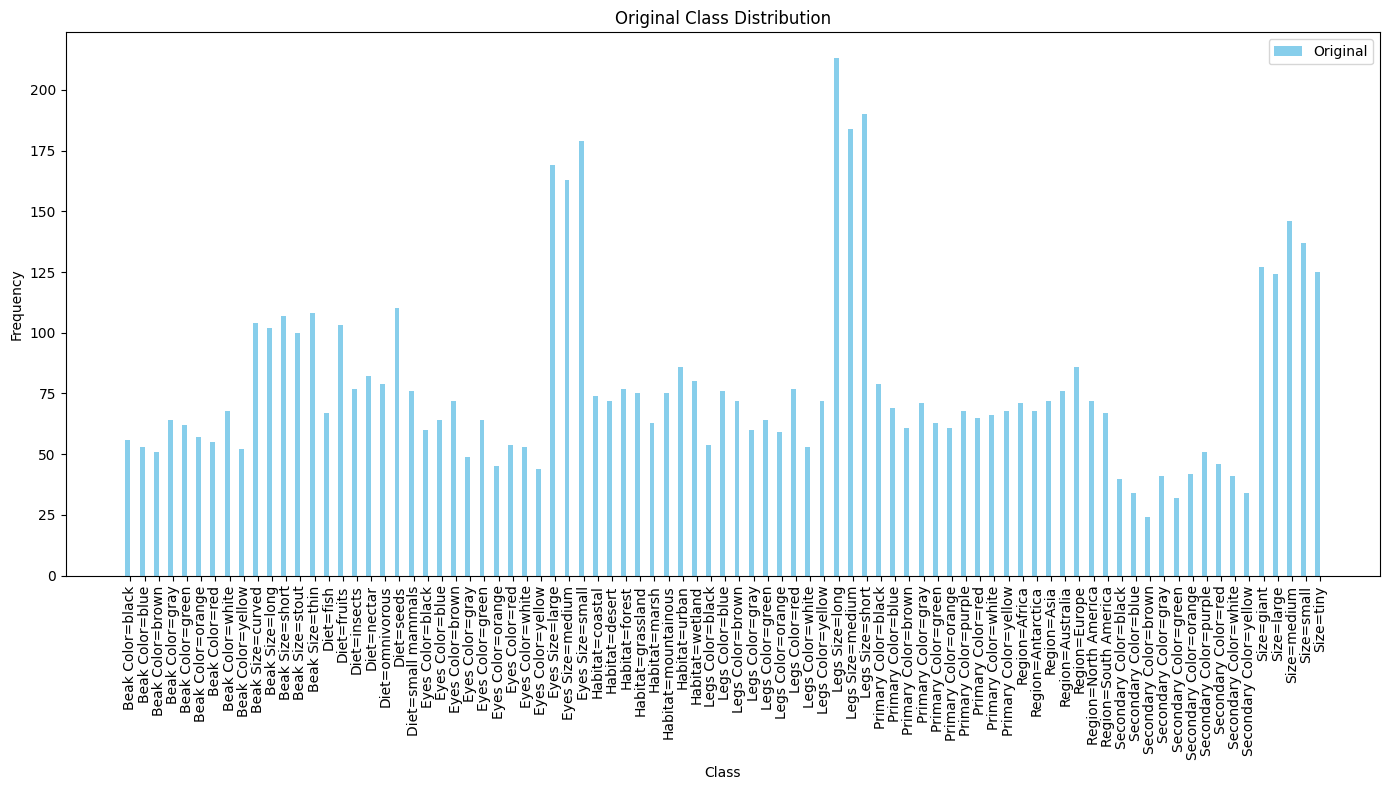

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate class frequencies
original_frequencies = np.sum(y_train_org, axis=0)
class_names = mlb.classes_

# Step 2: Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Class': class_names,
    'Original Frequency': original_frequencies
})

# Step 3: Plot using Matplotlib
x = np.arange(len(class_names))  # Class indices
width = 0.35  # Width of the bars

plt.figure(figsize=(14, 8))
plt.bar(x - width/2, comparison_df['Original Frequency'], width, label='Original', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Original Class Distribution')
plt.xticks(x, class_names, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# XGBoost

In [107]:
class_weights = []
for i in range(y_train_org.shape[1]):
    class_weights.append({0: 1, 1: np.sum(y_train_org[:, i] == 0) / np.sum(y_train_org[:, i] == 1)})

print((class_weights))

[{0: 1, 1: 14.0}, {0: 1, 1: 14.849056603773585}, {0: 1, 1: 15.470588235294118}, {0: 1, 1: 12.125}, {0: 1, 1: 12.548387096774194}, {0: 1, 1: 13.736842105263158}, {0: 1, 1: 14.272727272727273}, {0: 1, 1: 11.352941176470589}, {0: 1, 1: 15.153846153846153}, {0: 1, 1: 7.076923076923077}, {0: 1, 1: 7.235294117647059}, {0: 1, 1: 6.850467289719626}, {0: 1, 1: 7.4}, {0: 1, 1: 6.777777777777778}, {0: 1, 1: 11.537313432835822}, {0: 1, 1: 7.155339805825243}, {0: 1, 1: 9.909090909090908}, {0: 1, 1: 9.24390243902439}, {0: 1, 1: 9.632911392405063}, {0: 1, 1: 6.636363636363637}, {0: 1, 1: 10.052631578947368}, {0: 1, 1: 13.0}, {0: 1, 1: 12.125}, {0: 1, 1: 10.666666666666666}, {0: 1, 1: 16.142857142857142}, {0: 1, 1: 12.125}, {0: 1, 1: 17.666666666666668}, {0: 1, 1: 14.555555555555555}, {0: 1, 1: 14.849056603773585}, {0: 1, 1: 18.09090909090909}, {0: 1, 1: 3.970414201183432}, {0: 1, 1: 4.153374233128834}, {0: 1, 1: 3.6927374301675977}, {0: 1, 1: 10.35135135135135}, {0: 1, 1: 10.666666666666666}, {0: 1, 

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Initialize a list to store predictions
y_pred_list = []

# Train a separate Random Forest model for each label
for i in range(y_train_org.shape[1]):
    # Calculate class weights for the current label
    class_weight = {0: 1, 1: np.sum(y_train_org[:, i] == 0) / np.sum(y_train_org[:, i] == 1)}

    # Train the model
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        class_weight=class_weight,  # Apply class weights
        random_state=42
    )
    rf.fit(X_train_org, y_train_org[:, i])

    # Predict for the current label
    y_pred = rf.predict(X_test_org)
    y_pred_list.append(y_pred)

In [119]:
# Combine predictions
y_pred_final = np.vstack(y_pred_list).T

print(y_pred_final.shape)
print(classification_report(y_test_org, y_pred_final, target_names=mlb.classes_))

(210, 85)
                        precision    recall  f1-score   support

      Beak Color=black       0.75      0.38      0.50        16
       Beak Color=blue       1.00      0.14      0.25        14
      Beak Color=brown       0.00      0.00      0.00        12
       Beak Color=gray       0.50      0.07      0.12        15
      Beak Color=green       0.00      0.00      0.00        16
     Beak Color=orange       1.00      0.11      0.20         9
        Beak Color=red       1.00      0.09      0.17        11
      Beak Color=white       0.75      0.17      0.27        18
     Beak Color=yellow       0.00      0.00      0.00         8
      Beak Size=curved       1.00      0.20      0.33        25
        Beak Size=long       0.92      0.50      0.65        24
       Beak Size=short       0.92      0.46      0.62        26
       Beak Size=stout       1.00      0.31      0.47        29
        Beak Size=thin       0.00      0.00      0.00        28
             Diet=fish       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [123]:
scale_pos_weights = []
for i in range(y_train_org.shape[1]):
    scale_pos_weights.append(np.sum(y_train_org[:, i] == 0) / np.sum(y_train_org[:, i] == 1))

In [135]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Train the model
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=1,  # Adjust for class imbalance
    random_state=42
)
clf = MultiOutputClassifier(xgb)
clf.fit(X_train_org, y_train_org)


MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))

In [136]:
y_pred = clf.predict(X_test_org)
print(classification_report(y_test_org, y_pred, target_names=mlb.classes_))

                        precision    recall  f1-score   support

      Beak Color=black       0.86      0.38      0.52        16
       Beak Color=blue       0.88      0.50      0.64        14
      Beak Color=brown       0.50      0.08      0.14        12
       Beak Color=gray       0.80      0.27      0.40        15
      Beak Color=green       0.67      0.12      0.21        16
     Beak Color=orange       1.00      0.44      0.62         9
        Beak Color=red       0.75      0.27      0.40        11
      Beak Color=white       0.80      0.22      0.35        18
     Beak Color=yellow       1.00      0.50      0.67         8
      Beak Size=curved       1.00      0.20      0.33        25
        Beak Size=long       0.93      0.58      0.72        24
       Beak Size=short       0.93      0.54      0.68        26
       Beak Size=stout       1.00      0.45      0.62        29
        Beak Size=thin       0.00      0.00      0.00        28
             Diet=fish       0.81      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Enhance XGBoost

In [139]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

# Compute sample weights for each label
n_samples, n_labels = y_train_org.shape
sample_weights = np.ones_like(y_train_org, dtype=np.float32)

for j in range(n_labels):
    positives = y_train_org[:, j].sum()
    if positives == 0:
        continue  # Skip if no positives
    negatives = n_samples - positives
    scale_pos_weight = negatives / positives
    sample_weights[:, j] = np.where(y_train_org[:, j] == 1, scale_pos_weight, 1.0)

print(sample_weights)

[[ 1.        14.849056   1.        ...  1.         1.         1.       ]
 [ 1.         1.         1.        ...  1.         5.1313868  1.       ]
 [ 1.         1.         1.        ...  1.         1.         1.       ]
 ...
 [14.         1.         1.        ...  1.         5.1313868  1.       ]
 [14.         1.         1.        ...  1.         1.         1.       ]
 [ 1.         1.         1.        ...  4.7534246  1.         1.       ]]


In [141]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
import numpy as np

# Initialize a list to store individual classifiers
classifiers = []

# Loop through each label
for i in range(y_train_org.shape[1]):
    # Compute sample weights for the current label
    positives = y_train_org[:, i].sum()
    if positives == 0:
        scale_pos_weight = 1.0  # No positives, no adjustment
    else:
        negatives = y_train_org.shape[0] - positives
        scale_pos_weight = negatives / positives

    # Train a separate XGBoost model for the current label
    xgb_enhance = XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=scale_pos_weight,  # Adjust for class imbalance
        random_state=42
    )
    xgb_enhance.fit(X_train_org, y_train_org[:, i])  # Train on the current label
    classifiers.append(xgb_enhance)

# Predict for all labels
y_pred = np.zeros_like(y_test_org)
for i, clf_enhance in enumerate(classifiers):
    y_pred[:, i] = clf_enhance.predict(X_test_org)

# Print the classification report
print(classification_report(y_test_org, y_pred, target_names=mlb.classes_))

                        precision    recall  f1-score   support

      Beak Color=black       0.43      0.38      0.40        16
       Beak Color=blue       0.58      0.50      0.54        14
      Beak Color=brown       0.20      0.25      0.22        12
       Beak Color=gray       0.32      0.40      0.35        15
      Beak Color=green       0.20      0.19      0.19        16
     Beak Color=orange       0.31      0.44      0.36         9
        Beak Color=red       0.18      0.27      0.21        11
      Beak Color=white       0.38      0.33      0.35        18
     Beak Color=yellow       0.36      0.50      0.42         8
      Beak Size=curved       0.50      0.28      0.36        25
        Beak Size=long       0.61      0.71      0.65        24
       Beak Size=short       0.54      0.54      0.54        26
       Beak Size=stout       0.53      0.55      0.54        29
        Beak Size=thin       0.24      0.36      0.29        28
             Diet=fish       0.65      

In [147]:
# Get the probability predictions (this is for multi-output classification)
y_pred_proba = clf.predict_proba(X_test_org)  # This will return a list of arrays for each output

# Initialize an empty array for adjusted predictions
y_pred_adjusted = np.zeros_like(y_test_org)

# Loop through each label and apply the threshold
for i in range(y_test_org.shape[1]):
    # Get the probabilities for the current label (use the second column for the positive class)
    proba = y_pred_proba[i][:, 1]  # Probabilities for the positive class (index 1)

    # Choose an appropriate threshold (you can set it dynamically or use a fixed threshold)
    threshold = 0.6  # Example threshold, can be adjusted as needed

    # Apply the threshold to get binary predictions
    y_pred_adjusted[:, i] = (proba >= threshold).astype(int)

# Now you can evaluate the adjusted predictions
from sklearn.metrics import classification_report
print(classification_report(y_test_org, y_pred_adjusted))


              precision    recall  f1-score   support

           0       1.00      0.38      0.55        16
           1       0.88      0.50      0.64        14
           2       1.00      0.08      0.15        12
           3       0.80      0.27      0.40        15
           4       0.67      0.12      0.21        16
           5       1.00      0.44      0.62         9
           6       1.00      0.27      0.43        11
           7       1.00      0.22      0.36        18
           8       1.00      0.50      0.67         8
           9       1.00      0.20      0.33        25
          10       1.00      0.54      0.70        24
          11       0.93      0.54      0.68        26
          12       1.00      0.45      0.62        29
          13       0.00      0.00      0.00        28
          14       0.81      0.68      0.74        19
          15       0.93      0.78      0.85        18
          16       0.95      0.69      0.80        29
          17       1.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [148]:
import numpy as np

# Compute label frequencies
label_counts = y_train_org.sum(axis=0)
label_names = mlb.classes_

# Identify minority labels (e.g., classes with <10% of the samples)
minority_threshold = 0.1 * len(y_train_org)
minority_labels = [label_names[i] for i in np.where(label_counts < minority_threshold)[0]]
minority_indices = np.where(label_counts < minority_threshold)[0]

print("Minority labels:", minority_labels)

Minority labels: ['Beak Color=black', 'Beak Color=blue', 'Beak Color=brown', 'Beak Color=gray', 'Beak Color=green', 'Beak Color=orange', 'Beak Color=red', 'Beak Color=white', 'Beak Color=yellow', 'Diet=fish', 'Diet=insects', 'Diet=nectar', 'Diet=omnivorous', 'Diet=small mammals', 'Eyes Color=black', 'Eyes Color=blue', 'Eyes Color=brown', 'Eyes Color=gray', 'Eyes Color=green', 'Eyes Color=orange', 'Eyes Color=red', 'Eyes Color=white', 'Eyes Color=yellow', 'Habitat=coastal', 'Habitat=desert', 'Habitat=forest', 'Habitat=grassland', 'Habitat=marsh', 'Habitat=mountainous', 'Habitat=wetland', 'Legs Color=black', 'Legs Color=blue', 'Legs Color=brown', 'Legs Color=gray', 'Legs Color=green', 'Legs Color=orange', 'Legs Color=red', 'Legs Color=white', 'Legs Color=yellow', 'Primary Color=black', 'Primary Color=blue', 'Primary Color=brown', 'Primary Color=gray', 'Primary Color=green', 'Primary Color=orange', 'Primary Color=purple', 'Primary Color=red', 'Primary Color=white', 'Primary Color=yellow',